### 3.1 Formal Notation ###
It is a frequent belief that tensorflow is only 'good' for neural networks. This is not at all so. In this chapter, we will perform the classic supervised algorithm called __Linear Regression__.

<table style="text-align:center">
    <thead>
        <tr>
            <th>Train Accuracy</th>
            <th>Test Accuracy</th>
            <th>Result</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="color:green">High</td>
            <td style="color:green">High</td>
            <td>OK <br> &nbsp;</td>
        </tr>
        <tr>
            <td style="color:red">Low</td>
            <td style="color:green">High</td>
            <td>Not OK:<br> underfit</td>
        </tr>
        <tr>
            <td style="color:green" >High</td>
            <td style="color:red">Low</td>
            <td>Not OK:<br> overfit</td>
        </tr>
    </tbody>
</table>

__Underfitting__ occurs when our model performs well on the test set but poorly on the training set. This situation indicates an underfit: High variance and low bias. We could have performed better by training more. <br>
The opposite situation is __overfitting__ and happens when we train too long. In this situations the training accuracy increases - low variance - but our test accuracy decreases - high bias. An overfitted model is biased towards the training set (it memorises the training data) and generalises badly on unseen data. <br>

### 3.2 Linear Regression ###
Below we demonstrate linear regression using some fake data created with numpy:

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

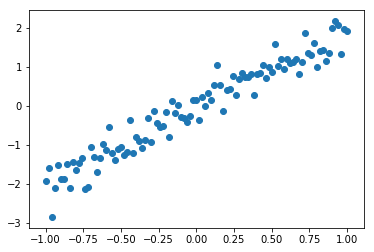

In [3]:
x_train = np.linspace(-1, 1, 101)
y_train = 2 * x_train + np.random.randn(*x_train.shape) * 0.33

plt.scatter(x_train, y_train)
plt.show()

Next, we use TensorFlow to estimate the line of best fit. For this to work, we need to rephrase our problem as a cost minimisation problem. I.e. we need to define a cost function such that, the further away our line is from the data, the higher the cost. <br>
Minimising that cost with respect to the parameter ___w___, the line slope, yields the line of best fit.

weight in epoch 0: 0.9763985872268677
weight in epoch 20: 1.9569166898727417
weight in epoch 40: 1.9569171667099
weight in epoch 60: 1.9569171667099
weight in epoch 80: 1.9569171667099


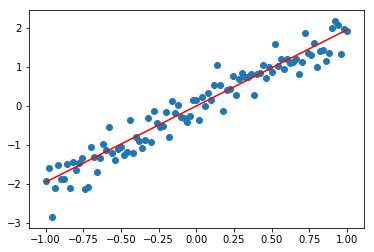

In [9]:

learning_rate = 0.01
training_epochs = 100

# Define the placeholders for the training data and labels
X = tf.placeholder("float")
Y = tf.placeholder("float")


# Define the variable that will be trained
w = tf.Variable(0.0, name="weights")

# Define the model equation
def model(X, w):
    return tf.multiply(X, w) 
y_model = model(X, w)

# Define the cost function
cost = tf.square(Y-y_model)
 
# Set it up as a cost minimisation problem
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Create a session
sess = tf.Session()

# Initialise the session's tensor variables
init = tf.global_variables_initializer()
sess.run(init)


for epoch in range(training_epochs):
    for (x, y) in zip(x_train, y_train):
        sess.run(train_op, feed_dict={X: x, Y: y})
        currentW = w.eval(session = sess)
    
    if epoch % 20 == 0:
        print("weight in epoch {}: {}".format(epoch, currentW))

w_val = sess.run(w)
 
sess.close()
plt.scatter(x_train, y_train)
y_learned = x_train*w_val
plt.plot(x_train, y_learned, 'r')
plt.show()

### 3.3 Polynomial Model ###
Linear models are often too simplistic to properly fit data in lots of situations. Consider for example of parabolic projectile motion or WiFi signal strength degrading with an inverse square law. In these situations we need to use a polynomial model of order __n > 1__. 

$$f(x) = w_nx^n + ... + w_1x + w_0$$



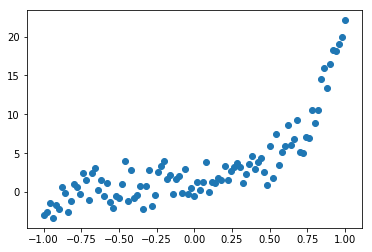

In [24]:
trX = np.linspace(-1, 1, 101)

num_coeffs = 6
trY_coeffs = [1,2,3,4,5,6]
trY = 0

for i in range(len(trY_coeffs)):
    trY += trY_coeffs[i] * np.power(trX, i)
    
trY += np.random.randn(*trX.shape) * 1.5
plt.scatter(trX, trY)
plt.show()
    

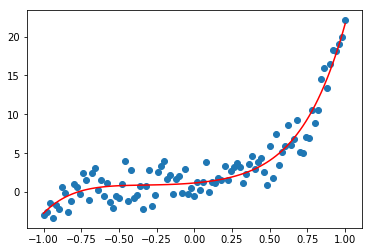

In [29]:
learning_rate = 0.01
training_epochs = 40

X = tf.placeholder("float")
Y = tf.placeholder("float")

w = tf.Variable([0.] * num_coeffs, name="parameters")
def model(X, w):
    terms = []
    for i in range(num_coeffs):
        term = tf.multiply(w[i], tf.pow(X, i))
        terms.append(term)
    
    return tf.add_n(terms)

y_model = model(X, w)
cost = tf.pow(Y - y_model, 2)
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(training_epochs):
    for x,y in zip(trX, trY):
        sess.run(train_op, feed_dict = {X: x, Y: y})
        w_val = sess.run(w)
        
    if epoch % 5 == 0:
        print('epoch {}, w: {}'.format(epoch, w_val))

sess.close()
plt.scatter(trX, trY)

trY2 = 0
for i in range(num_coeffs):
    trY2 += w_val[i] * np.power(trX, i)
    
plt.plot(trX, trY2, 'r')
plt.show()


### 3.4 Regularisation ###

Just because polynomials allow our models to become flexible, doesn't mean we should always prefer them. Too expressive models will fit the training data well but will likely fail to generalise (i.e. overfit). _Regularisation_ is a technique that penalises our model weight coefficients for being too many or too impactful. <br>
This influences the algorithm to produce a smaller coefficient vector. To control the 'amount' of penalty, we multiply it by a non-negative number __λ__:
$$ Cost(X,Y) = Loss(X,Y) + \lambda |w|$$

To figure out which __λ__ value works best, we make a 70-30 split of our data. The 70% will be used for training and the rest 30% for testing. Below we start by splitting the dataset:

In [32]:
def split_dataset(x_dataset, y_dataset, ratio):
    arr = np.arange(x_dataset.size)
    np.random.shuffle(arr)
    num_train = int(ratio * x_dataset.size)
    x_train = x_dataset[arr[0:num_train]]
    y_train = y_dataset[arr[0:num_train]]
    x_test = x_dataset[arr[num_train:x_dataset.size]]
    y_test = y_dataset[arr[num_train:x_dataset.size]]
    return x_train, x_test, y_train, y_test

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
 
learning_rate = 0.001
training_epochs = 1000
reg_lambda = 0.
 
x_dataset = np.linspace(-1, 1, 100)
 
num_coeffs = 9
y_dataset_params = [0.] * num_coeffs
y_dataset_params[2] = 1
y_dataset = 0
for i in range(num_coeffs):
    y_dataset += y_dataset_params[i] * np.power(x_dataset, i)
y_dataset += np.random.randn(*x_dataset.shape) * 0.3
 
(x_train, x_test, y_train, y_test) = split_dataset(x_dataset, y_dataset, 0.7)
 
X = tf.placeholder("float")
Y = tf.placeholder("float")
 
def model(X, w):
    terms = []
    for i in range(num_coeffs):
        term = tf.multiply(w[i], tf.pow(X, i))
        terms.append(term)
    return tf.add_n(terms)
 
w = tf.Variable([0.] * num_coeffs, name="parameters")
y_model = model(X, w)
cost = tf.div(tf.add(tf.reduce_sum(tf.square(Y-y_model)),
                     tf.multiply(reg_lambda, tf.reduce_sum(tf.square(w)))),
              2*x_train.size)
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
 
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
 
for reg_lambda in np.linspace(0,1,100):
    for epoch in range(training_epochs):
        sess.run(train_op, feed_dict={X: x_train, Y: y_train})
    final_cost = sess.run(cost, feed_dict={X: x_test, Y:y_test})
    print('reg lambda', reg_lambda)
    print('final cost', final_cost)
 
sess.close()

reg lambda 0.0
final cost 0.0369631
reg lambda 0.010101010101
final cost 0.0269936
reg lambda 0.020202020202
final cost 0.0237119
reg lambda 0.030303030303
final cost 0.0221847
reg lambda 0.040404040404
final cost 0.0214184
reg lambda 0.0505050505051
final cost 0.0210827
reg lambda 0.0606060606061
final cost 0.021013
reg lambda 0.0707070707071
final cost 0.0211091
reg lambda 0.0808080808081
final cost 0.0213051
reg lambda 0.0909090909091
final cost 0.0215574
reg lambda 0.10101010101
final cost 0.0218369
reg lambda 0.111111111111
final cost 0.0221249
reg lambda 0.121212121212
final cost 0.0224093
reg lambda 0.131313131313
final cost 0.0226831
reg lambda 0.141414141414
final cost 0.0229421
reg lambda 0.151515151515
final cost 0.0231845
reg lambda 0.161616161616
final cost 0.0234099
reg lambda 0.171717171717
final cost 0.0236183
reg lambda 0.181818181818
final cost 0.0238108
reg lambda 0.191919191919
final cost 0.0239884
reg lambda 0.20202020202
final cost 0.0241523
reg lambda 0.212121212

In [36]:
help(np.random.normal)

Help on built-in function normal:

normal(...) method of mtrand.RandomState instance
    normal(loc=0.0, scale=1.0, size=None)
    
    Draw random samples from a normal (Gaussian) distribution.
    
    The probability density function of the normal distribution, first
    derived by De Moivre and 200 years later by both Gauss and Laplace
    independently [2]_, is often called the bell curve because of
    its characteristic shape (see the example below).
    
    The normal distributions occurs often in nature.  For example, it
    describes the commonly occurring distribution of samples influenced
    by a large number of tiny, random disturbances, each with its own
    unique distribution [2]_.
    
    Parameters
    ----------
    loc : float
        Mean ("centre") of the distribution.
    scale : float
        Standard deviation (spread or "width") of the distribution.
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, 